<a href="https://colab.research.google.com/github/brian-ho/mde-preterm-2024/blob/main/XML_to_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XML to CSV

```
2024 MDE Preterm
Brian Ho - brian@brian-ho.io
Jenny Fan - me@jennyfan.com
```

Demonstration of parsing an XML file to a CSV file.

In [59]:
import xml.etree.ElementTree as ET
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
# When running on Colab, we can connect to a Google Drive folder
from google.colab import drive

drive.mount("/content/drive")

In [62]:
# Loads a "tree" representing the XML's hierarchical structure
tree = ET.parse(
    "/Users/brianho/Developer/GitHub/mde-preterm-2024/day_2/notebooks/example_data/trace.gpx"
)

# Get the singe node at the top-most (or bottom-most, depending how you think of it) part of the tree
root = tree.getroot()

In [63]:
# An empty array to store the processed data
data = []

# Iterate over each matching node in the XML file
for i, trkpt_node in enumerate(root.findall(".//{*}trkpt")):

    # Get the relevant attributes, parsing as needed
    lat = float(trkpt_node.get("lat"))
    lon = float(trkpt_node.get("lon"))
    ele = float(trkpt_node.find("./{*}ele").text)
    datetime = trkpt_node.find("./{*}time").text

    # Add the data to array
    data.append(
        {"latitude": lat, "longitude": lon, "elevation": ele, "datetime": datetime}
    )

In [64]:
# Load this into a Pandas DataFrame
df = pd.DataFrame(data)
df.describe()

,latitude,longitude,elevation
count,747.000000,747.000000,747.000000
mean,40.702327,-73.993129,19.155957
std,0.007899,0.008914,10.799842
min,40.693517,-74.010414,5.400000
25%,40.694373,-74.001866,11.600000
50%,40.700883,-73.990230,14.600000
75%,40.710004,-73.987173,23.750000
max,40.716172,-73.978481,43.100000


In [65]:
# Convert the time string to a true datetime object
df["datetime"] = pd.to_datetime(df["datetime"])

# Sort by time
df = df.sort_values(by="datetime")

# Add additional columns to the data: geometry and the elapsed time
df["elapsed_time_seconds"] = (df["datetime"] - df["datetime"].min()).dt.total_seconds()
df["geometry"] = df.apply(
    lambda x: Point(float(x.longitude), float(x.latitude)), axis=1
)

<Axes: xlabel='elapsed_time_seconds', ylabel='elevation'>

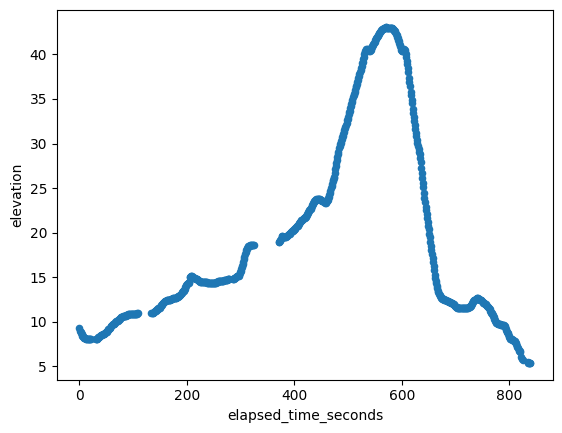

In [67]:
# Let's plot the elapsed time
df[df["elapsed_time_seconds"] < 2000].plot.scatter(
    x="elapsed_time_seconds", y="elevation"
)

<Axes: xlabel='elapsed_time_seconds', ylabel='elevation'>

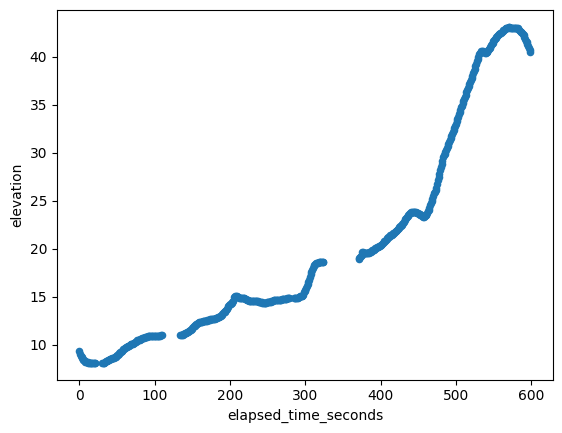

In [36]:
# We can filter the dataset as needed
df[df["elapsed_time_seconds"] < 600].plot.scatter(
    x="elapsed_time_seconds", y="elevation"
)

<Axes: >

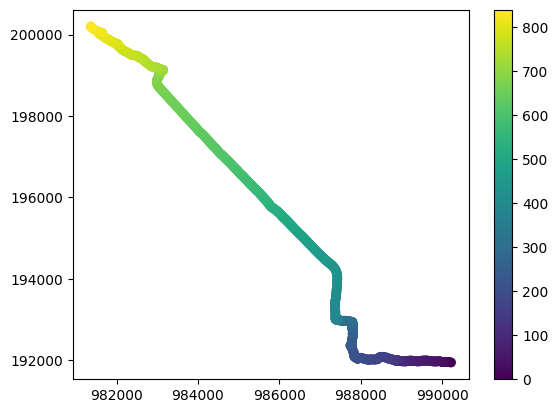

In [68]:
# Plot this as a GeoDataFrame, using a CRS for New York
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="4326")
gdf = gdf.to_crs("2263")

gdf.plot(column="elapsed_time_seconds", legend=True)

<Axes: xlabel='elapsed_time_seconds', ylabel='distance_since_previous'>

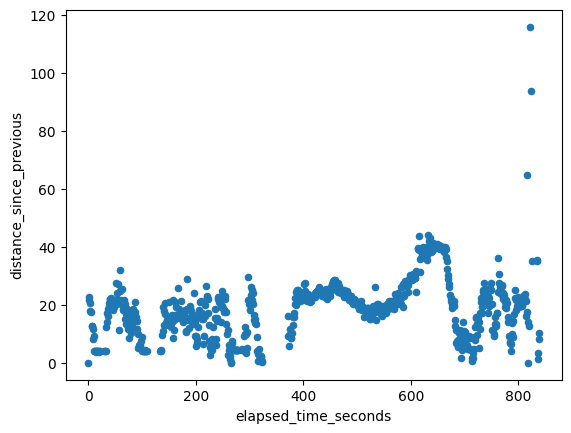

In [69]:
# Compute more complex columns based on others
gdf["previous_geometry"] = gdf["geometry"].shift(1)
gdf["distance_since_previous"] = gdf.apply(
    lambda x: x["geometry"].distance(x["previous_geometry"]), axis=1
)
gdf.loc[0, "distance_since_previous"] = 0

# Basic plotting
gdf.plot.scatter(x="elapsed_time_seconds", y="distance_since_previous", legend=True)

<Axes: >

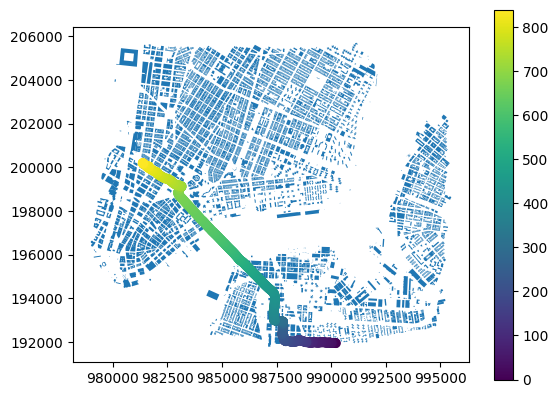

In [71]:
# Load a geojson with building information, on the same CRS
gdf_buildings = gpd.read_file(
    "/Users/brianho/Developer/GitHub/mde-preterm-2024/day_2/notebooks/example_data/buildings.geojson"
).to_crs("2263")

# Plot our trace and buildings
ax = gdf_buildings.plot()
gdf.plot(column="elapsed_time_seconds", legend=True, ax=ax)

In [79]:
gdf_buildings

,base_bbl,cnstrct_yr,doitt_id,groundelev,heightroof,mpluto_bbl,name,geometry
0,1003060013,1900.0,512541.0,39.0,73.130000,1003060013,None,"POLYGON ((986180.447 200723.052, 986187.771 20..."
1,3024050006,1899.0,663480.0,50.0,35.566775,3024050006,None,"POLYGON ((994482.001 199485.455, 994472.94 199..."
2,3021370021,1920.0,244666.0,44.0,37.003867,3021370021,None,"POLYGON ((994182.966 197736.123, 994182.881 19..."
3,1003760007,1900.0,555544.0,8.0,54.299846,1003760007,None,"POLYGON ((990203.165 202993.016, 990192.215 20..."
4,3023570024,1960.0,840996.0,26.0,26.390000,3023570024,None,"POLYGON ((994316.477 200599.075, 994280.826 20..."
...,...,...,...,...,...,...,...,...
11863,3021730004,2022.0,1300202.0,52.0,54.000000,3021730004,None,"POLYGON ((994374.354 196683.129, 994423.242 19..."
11864,1005800052,2020.0,337319.0,17.0,183.000000,1005807502,None,"POLYGON ((982541.359 204451.1, 982529.435 2043..."
11865,3000430012,2022.0,1298231.0,37.0,60.000000,3000437501,None,"POLYGON ((989142.676 195361.318, 989217.357 19..."
11866,3020270011,2022.0,1298378.0,15.0,70.000000,3020277503,None,"POLYGON ((990531.898 193312.265, 990601.688 19..."


In [44]:
# Save a CSV
gdf.to_csv("../p5/tutorial/data/data.csv", index=False)

/var/folders/bc/767gycqn4xl3mnnpt7qhjtt40000gn/T/ipykernel_84364/543121193.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  trace_geom = gdf.geometry.buffer(400).unary_union


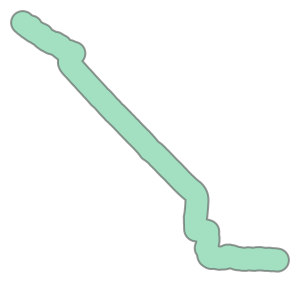

In [81]:
trace_geom = gdf.geometry.buffer(400).unary_union
trace_geom

/var/folders/bc/767gycqn4xl3mnnpt7qhjtt40000gn/T/ipykernel_84364/3737023934.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  trace_geom = gdf.geometry.buffer(800).unary_union


<Axes: >

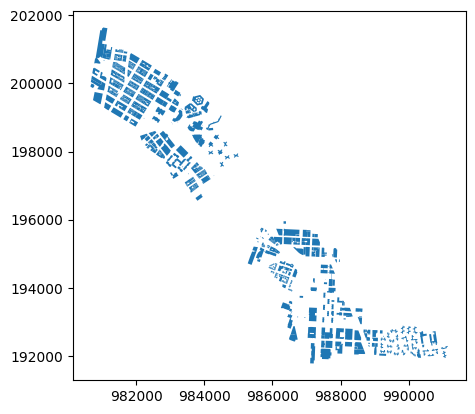

In [83]:
trace_geom = gdf.geometry.buffer(800).unary_union

gdf_buildings_nearby = gdf_buildings[gdf_buildings["geometry"].intersects(trace_geom)]
gdf_buildings_nearby.plot()

In [58]:
gdf_buildings_nearby.to_crs(4326).to_file(
    "../p5/tutorial/data/nearby_buildings.json", driver="GeoJSON"
)